# IMAGE DATA PROCESSING OR GENERATION, IN GENERAL
- [Classification resources](https://www.uspto.gov/web/patents/classification/cpc/html/cpc-G06T.html)
- [Data](https://gerdes.fr/saclay/informationRetrieval/patentFiles/G06T.txt.gz)

## 🪐 Authors
- Dana AUBAKIROVA
- Benedicutus Kent RACHMAT

## I. IMPORTS

Uncomment this line if you don't have the text file 

In [1]:
# !python -m spacy download en_core_web_lg
# !pip install trankit
# !pip install spacy==3.4.4
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_sm-0.4.0.tar.gz
# !pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_trf-3.2.0/en_core_web_trf-3.2.0-py3-none-any.whl

In [2]:
# !wget https://gerdes.fr/saclay/informationRetrieval/patentFiles/G06T.txt.gz -P texts
# !gzip -d G06T.txt.gz

In [3]:
import re
from lib import *
import numpy as np
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm
from trankit import Pipeline

import spacy
from spacy import displacy
from spacy.tokens import Span
from spacy.tokens import DocBin
from spacy.util import filter_spans
from spacy.matcher import PhraseMatcher
from scispacy.hyponym_detector import HyponymDetector

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
FUNKY_COLOR = "linear-gradient(90deg, #aa9cfc, #fc9ce7)"

## II. EXPLORATORY ANALYSIS

In [5]:
g06t = open('texts/G06T.txt').read().strip()
patent_texts = g06t.split('\n\n')
patent_lines = g06t.split('\n')

print(len(patent_lines), 'paragraphs of patent text')

# large english pre-trained language model
nlp = spacy.load("en_core_web_lg")
shorttext = patent_texts[0][18000:20000]
doc = nlp(shorttext)
displacy.render(doc, style="ent", jupyter=True)

298995 paragraphs of patent text


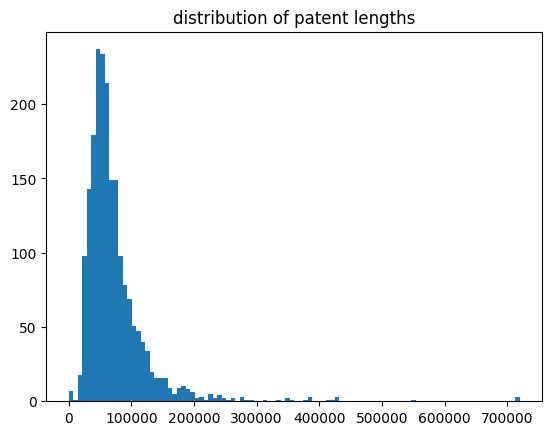

In [6]:
# distribution of patent lengths
patent_lengths = [len(p) for p in patent_texts]
plt.hist(patent_lengths, bins=100)
plt.title("distribution of patent lengths")
plt.show()

The function extracts reference numerals and their corresponding terms from a given text. It filters out unwanted terms and returns a dictionary with reference numerals as keys and lists of related terms as values. This helps the model to remove ambigiouty from the numbers

In [7]:
num2termlist = rawExtractRefs(shorttext)
print("References numbers and terms:")
display(num2termlist)

References numbers and terms:


{400: ['method'],
 401: ['begins at step'],
 102: ['background data stream'],
 402: ['step'],
 101: ['foreground data stream'],
 403: ['step'],
 404: ['step'],
 100: ['high bit rate stream'],
 406: ['step']}

Removing the References numbers and the determiners from the text.

In [8]:
remove_list = ['r']
exclude_list = ['FIG', 'FIGS']
cleanNshort = removeNumbers(shorttext, num2termlist)
doc = nlp(cleanNshort) 

noun_chunks = get_noun_chunks_v2(doc, remove_list, exclude_list)

displacy.render({'text': cleanNshort, 'ents': noun_chunks, 'title': "Improved Noun Chunks without determiners"},
                style='ent', options={'colors': {"NC": FUNKY_COLOR}}, manual=True, jupyter=True)

Adding the predicates

In [9]:
doc = nlp(cleanNshort)
displacy.render(doc, style="dep")
noun_chunks = get_noun_chunks_v2(doc, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks(doc, noun_chunks)

displacy.render({'text': cleanNshort, 'ents': noun_chunks + predicates,
                'title': None}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": FUNKY_COLOR}})

#### Semantic Graph Representation 

inspired by [Knowledge-Graph-Spacy](https://www.kaggle.com/code/cananserper/knowledge-graph-spacy) 

In [12]:
df = pd.DataFrame({'source': [str(s) for s in sources], 'target': [str(t) for t in targets], 'edge': [r['text'] for r in predicates]})
df.head(10)

,source,target,edge
0,method,variation,is
1,variation,widely known MPEG-DASH standard,of
2,available streams,previous embodiments,to
3,method,step,at
4,step,reception,with
5,reception,subsequent presentation,for
6,subsequent presentation,background data stream,of
7,background data stream,information,on
8,information,information data,present in blending
9,information data,other information,on


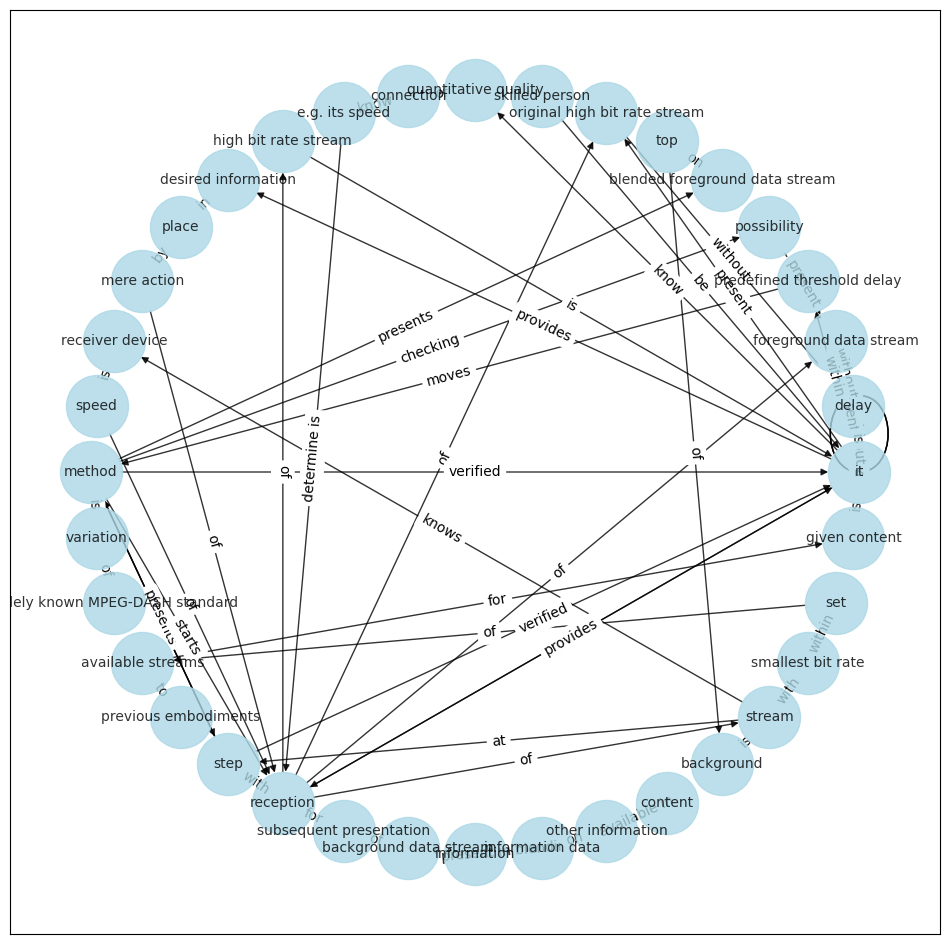

In [13]:
G = nx.from_pandas_edgelist(df, "source", "target",
                            edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12, 12))

pos = nx.shell_layout(G)
nx.draw_networkx(G, with_labels=True, pos=pos, node_size=2000, node_color='lightblue', edge_color='black', width=1, alpha=0.8, font_size=10)

edge_labels = {(row['source'], row['target']): row['edge']
               for _, row in df.iterrows()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()



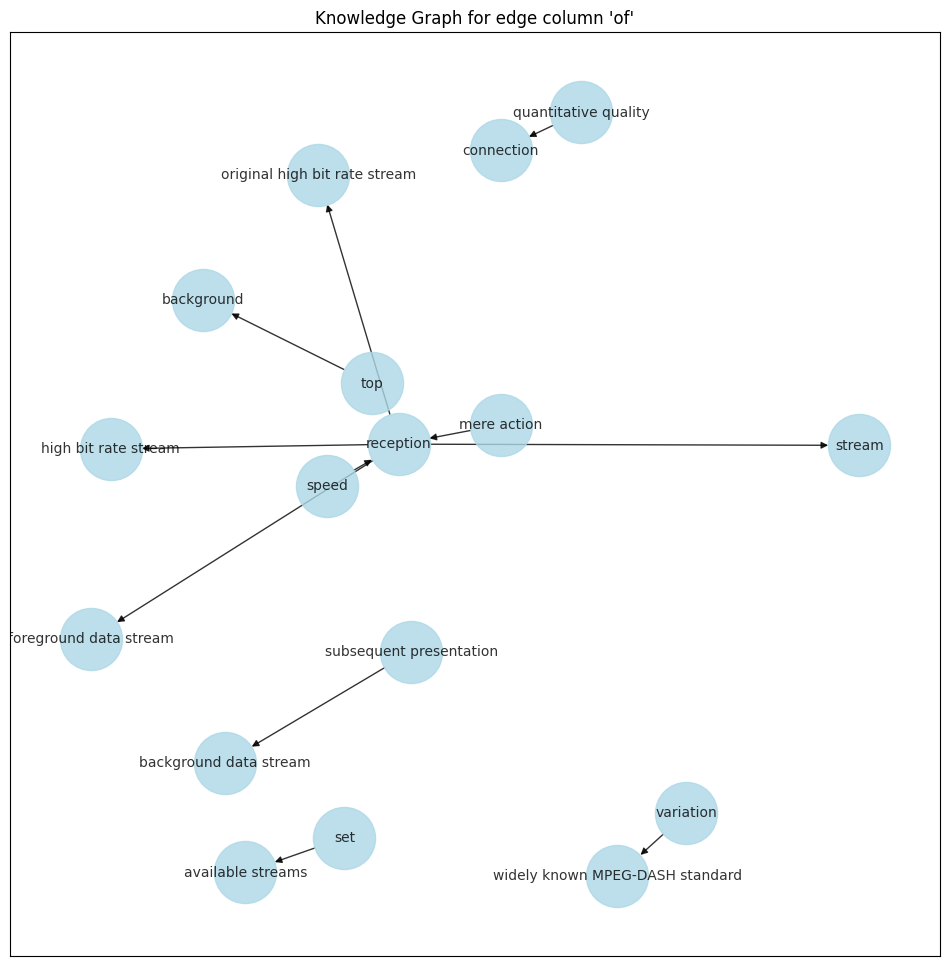

In [14]:
G=nx.from_pandas_edgelist(df[df['edge']=="of"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw_networkx(G, with_labels=True, pos=pos, node_size=2000, node_color='lightblue', edge_color='black', width=1, alpha=0.8, font_size=10)
plt.title("Knowledge Graph for edge column 'of'")
plt.show()

In [18]:
train_lines, test_lines = train_test_split(patent_lines, test_size=0.3, random_state=42)

In [30]:
for i,lines in enumerate(train_lines[:50000]):
    try:
        num2termlist = rawExtractRefs(lines)
        cleanNshort = removeNumbers(lines, num2termlist)
        test_lines[int(i)] = cleanNshort
    except:
        pass

In [27]:
for i,lines in enumerate(test_lines[:7000]):
    num2termlist = rawExtractRefs(lines)
    cleanNshort = removeNumbers(lines, num2termlist)
    test_lines[int(i)] = cleanNshort

## III. Spacy

In [15]:
cvectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english', min_df=500)  
X=cvectorizer.fit_transform(patent_lines)
Xdf = pd.DataFrame(np.sum(X, axis=0), columns=cvectorizer.get_feature_names_out()).T.sort_values(by = 0, ascending = False)

Xdf.columns = ['count']
Xdf.head(10)

,count
image data,27634
image processing,20995
present invention,17756
according embodiment,14986
present disclosure,14878
electronic device,11964
processing unit,11779
embodiment present,11362
shown fig,10331
control unit,9676


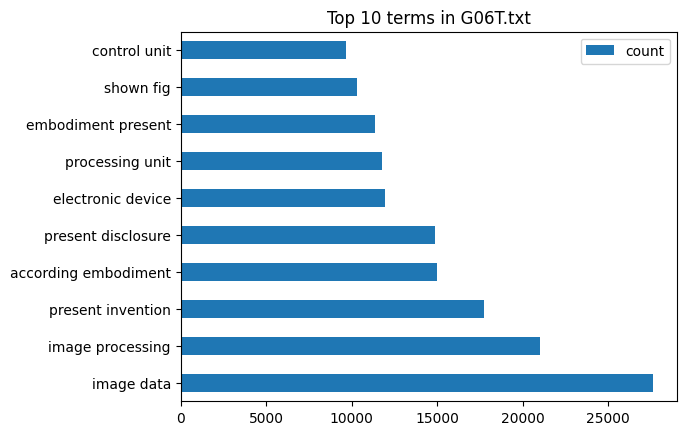

In [16]:
top_10 = Xdf.head(10)
top_10.plot.barh()
plt.title("Top 10 terms in G06T.txt")
plt.show()

In [17]:
def Dataset(split, dataset):
    LABEL = "ENTITY"
    doc_bin = DocBin()  

    for training_example in tqdm(dataset):  
        doc = nlp(training_example) 
        new_ents = []
        ents = list(doc.ents)

        for i in range(len(doc.ents)-1):
            k = i+1
            new_ent = ents[i]
            next_ent = ents[k]

            # check if there's only a space between
            # in that case, merge them
            while doc.text[new_ent.end_char:next_ent.start_char] == ' ':
                k += 1
                new_ent = Span(doc, new_ent.start, next_ent.end, label=LABEL)
                if k >= len(ents):
                    break
                # next entity to see if can be merged
                next_ent = ents[k]

            # don't add the entities with trailing spaces
            if new_ent.text.strip() != new_ent.text:
                continue
                
            new_ents.append(new_ent)

        filtered_ents = filter_spans(ents)
        doc.ents = filtered_ents 
        doc_bin.add(doc)

    doc_bin.to_disk("{}_data.spacy".format(split))
    print("Saved {} docs to {}".format(len(doc_bin), "{}_data.spacy".format(split)))
    return doc_bin

In [42]:
nlp = spacy.load("en_core_web_trf")
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
patterns = [nlp.make_doc(text) for text in Xdf.index]
matcher.add("TT", patterns)

In [18]:
doc_bin_train = Dataset('train',train_lines[:50000])
doc_bin_val = Dataset('val', test_lines[:5000])
doc_bin_test = Dataset('test', test_lines[5000:7000])

  0%|          | 0/50000 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors


Saved 50000 docs to train_data.spacy


  0%|          | 0/5000 [00:00<?, ?it/s]

Saved 5000 docs to val_data.spacy


  0%|          | 0/2000 [00:00<?, ?it/s]

Saved 2000 docs to test_data.spacy


In [21]:
nlp = spacy.load("en_core_sci_sm")
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
patterns = [nlp.make_doc(text) for text in Xdf.index]
matcher.add("TT", patterns)

In [22]:
doc_bin_train = Dataset('train',train_lines[:50000])
doc_bin_val = Dataset('val', test_lines[:5000])
doc_bin_test = Dataset('test', test_lines[5000:7000])

  0%|          | 0/50000 [00:00<?, ?it/s]

Saved 50000 docs to train_data.spacy


  0%|          | 0/5000 [00:00<?, ?it/s]

Saved 5000 docs to val_data.spacy


  0%|          | 0/2000 [00:00<?, ?it/s]

Saved 2000 docs to test_data.spacy


### Spacy Training

In [ ]:
# !python -m spacy init fill-config config/base_config.cfg config/config.cfg
# !python -m spacy train config.cfg --output ./spacy_output_img --paths.train ./train_data.spacy --paths.dev ./val_data.spacy

In [49]:
nlp_ner = spacy.load("./old_spacy_output/model-best")
doc = nlp_ner(patent_lines[5])
spacy.displacy.render(doc, style="ent", jupyter=True)

In [50]:
nlp_ner = spacy.load("./spacy_output/model-best")
doc = nlp_ner(patent_lines[5])
spacy.displacy.render(doc, style="ent", jupyter=True)

### III. Prodigy 

[Beta Tester](https://support.prodi.gy/t/beta-testers-wanted-new-manual-dependencies-relations-ui-v1-10/2893)

In [51]:
!prodigy ner.teach ner_tech  spacy_output_img/model-best  texts/G06T.txt --label TT 

Using 1 label(s): TT
/usr/local/anaconda3/lib/python3.9/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.4.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)

✨  Starting the web server at http://localhost:8080 ...
Open the app in your browser and start annotating!

^C


In [ ]:
!prodigy ner.correct gold_tech  ./spacy/spacy_output/model-best  G06T.txt --label TECH_M

In [ ]:
!prodigy ner.silver-to-gold gold_tech ner_tech ./spacy/spacy_output/model-best --label TECH_M 

In [ ]:
!prodigy data-to-spacy ./spacy/prodigy_output --ner gold_tech --eval-split 0.3

In [ ]:
!prodigy train ./spacy/prodigy_output --ner gold_tech --eval-split 0.3 --base-model ./spacy/spacy_output/model-best 

In [ ]:
!prodigy stats ner_tech #--label TECH_M

In [ ]:
nlp_ner = spacy.load("./spacy_output/model-best")

colors = {"TECH": "#7DF6D9", "TECH_M": "#7DF6D9"}
options = {"colors": colors} 

for line in test_lines[10000:10010]:
    doc = nlp_ner(line)
    spacy.displacy.render(doc, style="ent", options= options, jupyter=True)

# IV. Relation Detection

In [59]:
from spacy.tokens import Doc

if not Doc.has_extension("hyponyms"):
    Doc.set_extension("hyponyms", default=[])


In [61]:
import spacy
from spacy.language import Language
from spacy.tokens import Doc
from scispacy.hyponym_detector import HyponymDetector

if not Doc.has_extension("hyponyms"):
    Doc.set_extension("hyponyms", default=[])

@Language.factory("c_hyponym_detector")
def create_custom_hyponym_detector(nlp, name):
    return HyponymDetector(nlp, extended=True)

nlp = spacy.load("./spacy_output/model-best")
nlp.add_pipe("c_hyponym_detector", last=True)

In [63]:
doc._.hyponyms

[]

In [64]:
text = patent_lines[4]
doc = nlp(text)

for hyponym in doc._.hyponyms:
    print(f"Hyponym: {hyponym.term}, Hypernym: {hyponym.hypernym}")

### Co-occurrence

### Hyponym and Hypernym

In [70]:
import spacy
import re

nlp = spacy.load("en_core_web_sm")

def hearst_patterns(text):
    patterns = [
        (r"{NP1}<such as>{NP2}",
         lambda m: (m.group("NP1"), m.group("NP2"))),
        (r"such {NP1} as {NP2}",
         lambda m: (m.group("NP1"), m.group("NP2"))),
        (r"{NP1} or other {NP2}",
         lambda m: (m.group("NP1"), m.group("NP2"))),
        (r"{NP1}, including {NP2}",
         lambda m: (m.group("NP1"), m.group("NP2"))),
        (r"{NP1}, especially {NP2}",
         lambda m: (m.group("NP1"), m.group("NP2"))),
        (r"{NP1} such as {NP2}",
         lambda m: (m.group("NP1"), m.group("NP2"))),
        (r"{NP1}, notably {NP2}",
         lambda m: (m.group("NP1"), m.group("NP2"))),
        (r"{NP1}, among them {NP2}",
         lambda m: (m.group("NP1"), m.group("NP2"))),
    ]

    for pattern, action in patterns:
        for placeholder in ["NP1", "NP2"]:
            pattern = pattern.replace(
                f"{{{placeholder}}}",
                r"(?P<{}>{{\d+}})".format(placeholder),
            )
        regex = re.compile(pattern)
        for match in regex.finditer(text):
            yield action(match)

def extract_hypernyms_hyponyms(text):
    document = nlp(text)
    np_chunks = list(document.noun_chunks)

    np_chunks_text = {str(chunk): chunk for chunk in np_chunks}
    text_with_placeholders = document.text

    for idx, chunk in enumerate(np_chunks):
        text_with_placeholders = text_with_placeholders.replace(
            str(chunk), "{" + str(idx) + "}")

    results = list(hearst_patterns(text_with_placeholders))

    hypernyms_hyponyms = []

    for hypernym, hyponyms in results:
        hypernym_idx = int(hypernym.strip("{}"))
        hypernym = np_chunks[hypernym_idx]
        hyponyms = [np_chunks[int(hyponym.strip("{}"))] for hyponym in hyponyms.split(",")]
        hypernyms_hyponyms.append((hypernym, hyponyms))

    return hypernyms_hyponyms


# Sample usage
sample_text = "Image processing techniques, such as convolutional neural networks and autoencoders, are widely used."
hypernyms_hyponyms = extract_hypernyms_hyponyms(sample_text)

for hypernym, hyponyms in hypernyms_hyponyms:
    print(f"Hypernym: {hypernym}")
    print("Hyponyms:")
    for hyponym in hyponyms:
        print(f"  - {hyponym}")


In [69]:
# detect co-occurrence of the text
def get_co_occurrence(text):
    doc = nlp(text)
    matcher = PhraseMatcher(nlp.vocab)
    pattern = [{'POS': 'NOUN'}, {'LOWER': 'and'}, {'POS': 'NOUN'}]
    matcher.add('CoOccurrence', [pattern])
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]
        print(span.text)
        print(span.root.text)
        print(span.root.head.text)
        print([child for child in span.root.children])
        print("")

get_co_occurrence("A method for detecting a hyponym and a hypernym of a text.")

TypeError: unhashable type: 'dict'